# Treatment of Real Images

In [1]:
from pathlib import Path
import imageio.v2 as imageio
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

In [2]:
images_dir = Path("../Real-Images")  # change to your folder path if needed
files = sorted(images_dir.glob("*.tif"))
arr = imageio.imread(files[0])

In [3]:
arr.shape

(2052, 2560, 4)

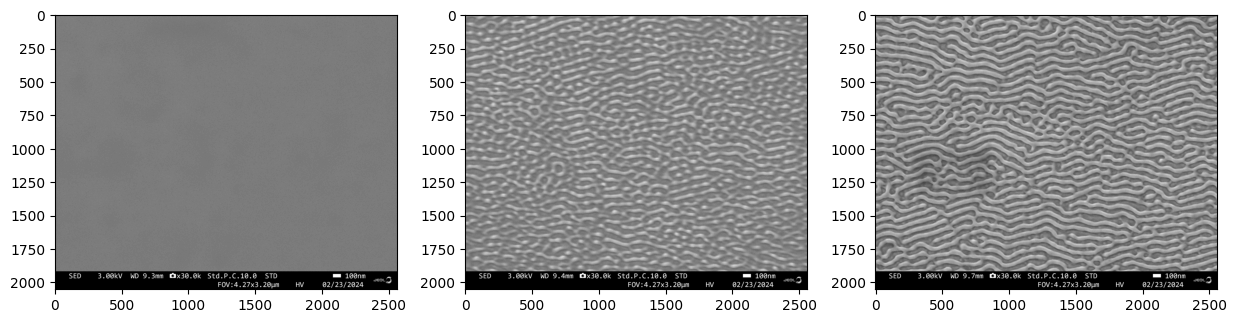

In [4]:
# Plot the 1st 25th and 50th image

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for number in ['1', '25', '50']:

    path = Path(f"../Real-Images/{number}.tif")
    arr = imageio.imread(path)

    axes[int(number) // 25].imshow(arr[: , :, 0], cmap='gray')
    #plt.imshow(arr[: , :, 0], cmap='gray')

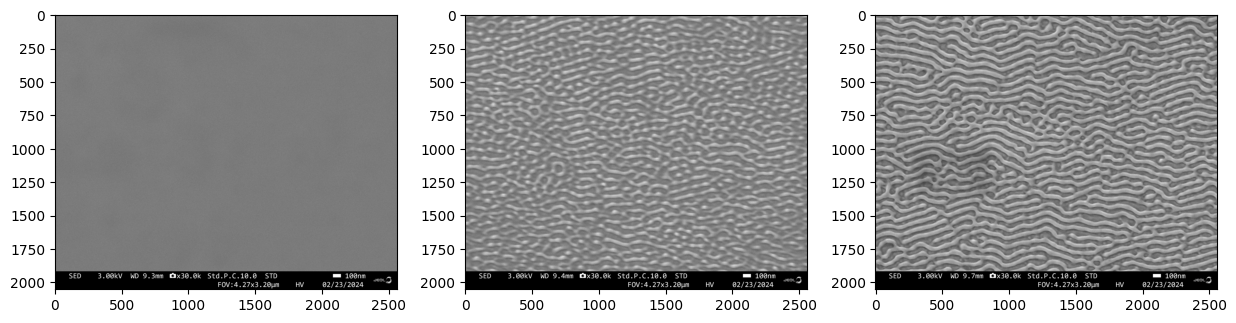

In [5]:
# Plot in RGB
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for number in ['1', '25', '50']:

    path = Path(f"../Real-Images/{number}.tif")
    arr = imageio.imread(path)

    axes[int(number) // 25].imshow(arr)

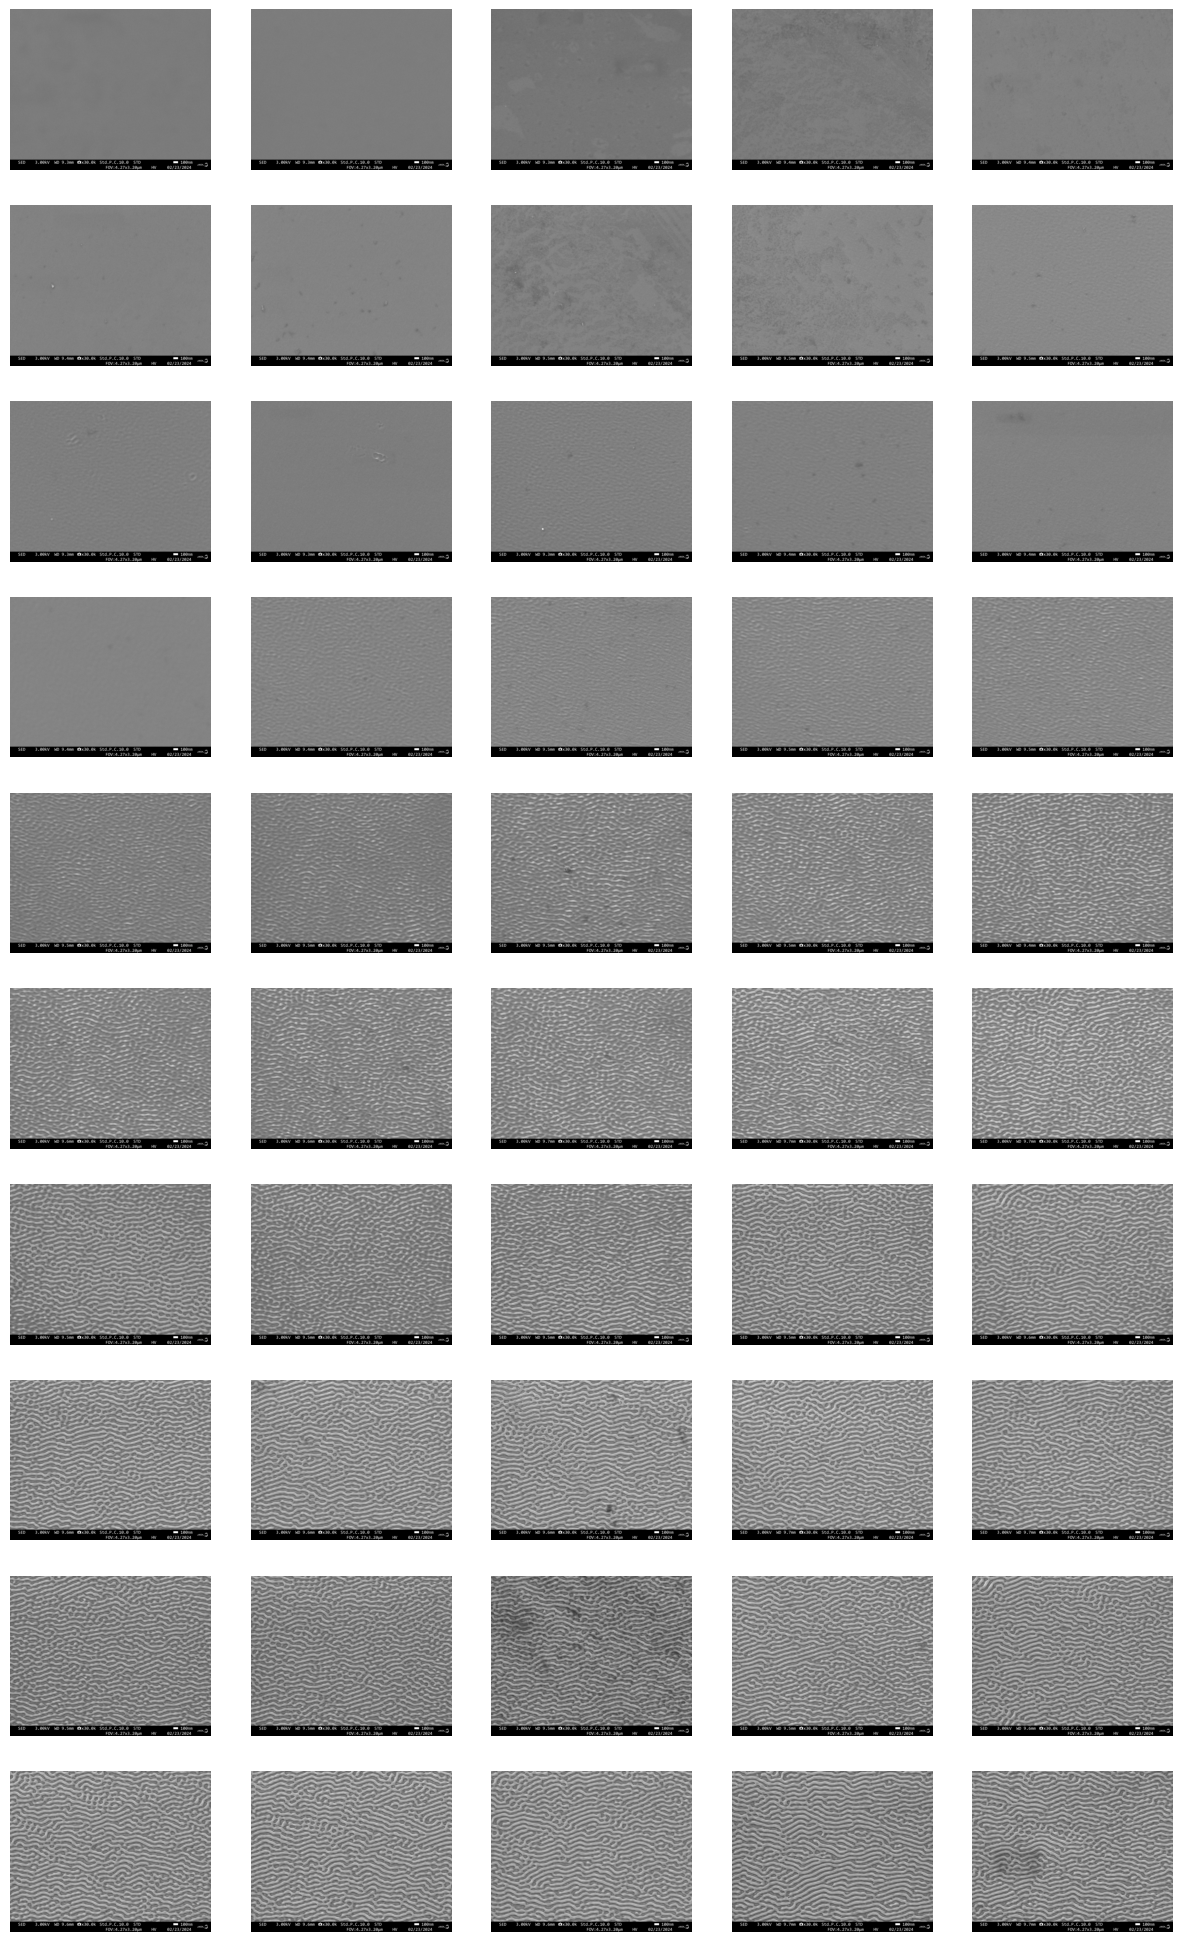

In [6]:
# PLot all 50 frames

fig, axes = plt.subplots(10, 5, figsize=(15, 25))

for number in [i for i in range(50)]:

    path = Path(f"../Real-Images/{number+1}.tif")
    arr = imageio.imread(path)

    r, c = divmod(number, 5)
    ax = axes[r, c]
    # show RGB (drop alpha) or grayscale as appropriate
    if arr.ndim == 3 and arr.shape[2] in (3, 4):
        ax.imshow(arr[..., :3])
    else:
        ax.imshow(arr, cmap='gray')
    ax.axis('off')
    #plt.imshow(arr[: , :, 0], cmap='gray')

KeyboardInterrupt: 

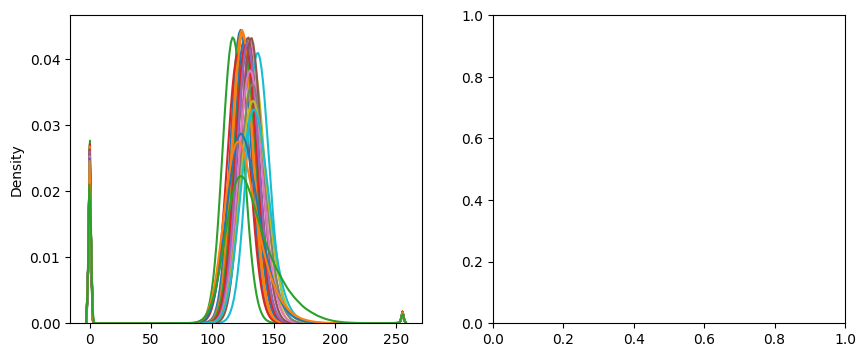

In [7]:
# Check the color distribution for these in one single kde plot
import seaborn as sns

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
for number in [i for i in range(50)]:

    path = Path(f"../Real-Images/{number+1}.tif")
    arr = imageio.imread(path)[:, :, 0]
    pixels = arr.ravel().astype(float)
    
    if number < 25:
        sns.kdeplot(pixels, bw_adjust=0.6, fill=False, ax=ax[0])
    else:
        sns.kdeplot(pixels, bw_adjust=0.6, fill=False, ax=ax[1])

plt.show()


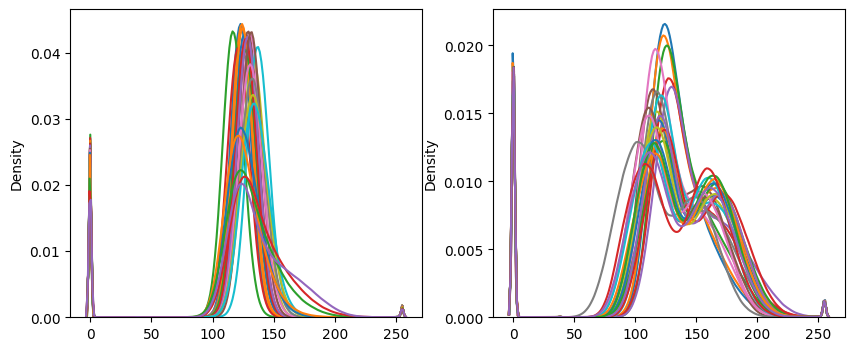

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
for number in [i for i in range(50)]:

    path = Path(f"../Real-Images/{number+1}.tif")
    arr = imageio.imread(path)[:, :, 1]
    pixels = arr.ravel().astype(float)
    
    if number < 25:
        sns.kdeplot(pixels, bw_adjust=0.6, fill=False, ax=ax[0])
    else:
        sns.kdeplot(pixels, bw_adjust=0.6, fill=False, ax=ax[1])

plt.show()

## SINDy in Real Images

In [16]:
import cv2

In [10]:
def read_image(number):

    path = Path(f"../Real-Images/{number}.tif")
    arr = imageio.imread(path)[:1800 , :, 0]  # get rid of the bottom black bar on each image 

    return arr

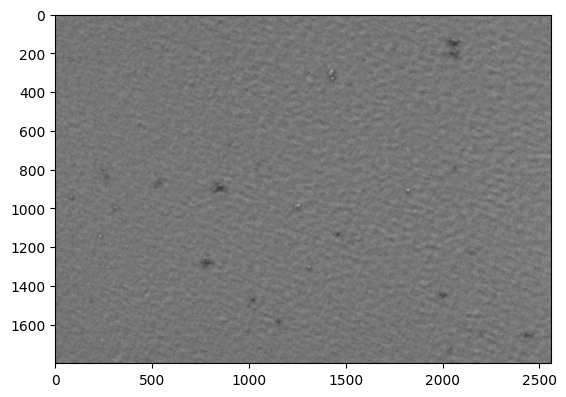

In [11]:
plt.imshow(read_image(10), cmap='gray')

In [29]:
def clean_image(arr,
                taille_median: int = 7, 
                taille_flat_field: int = 101,
                gamma: float = 0.7):

    # --- 2. NETTOYAGE TACHES (Median) ---
    # On s'assure que la taille est impaire
    if taille_median % 2 == 0: taille_median += 1
    img_clean = cv2.medianBlur(arr, taille_median)

    # --- 2b. BILATERAL FILTER (optional, better edge preservation) ---
    img_clean = cv2.bilateralFilter(img_clean, 9, 75, 75)

    # --- 3. CORRECTION ÉCLAIRAGE (Flat Field) ---
    img_float = img_clean.astype(np.float32)
    
    if taille_flat_field % 2 == 0: taille_flat_field += 1
    background = cv2.GaussianBlur(img_float, (taille_flat_field, taille_flat_field), 0)
    
    # Division par le fond (+ epsilon pour éviter div par 0)
    img_flat = img_float / (background + 1e-6)

    # --- 4. NORMALISATION ROBUSTE & GAMMA ---
    # On ignore les valeurs extrêmes (2% min et max) pour éviter le bruit
    p2, p98 = np.percentile(img_flat, (2, 98))
    
    # Normalisation entre 0 et 1
    img_norm = (img_flat - p2) / (p98 - p2 + 1e-6)
    img_norm = np.clip(img_norm, 0, 1)
    
    # Application du Gamma (optionnel, par défaut 1.0 ne fait rien)
    if gamma != 1.0:
        img_norm = np.power(img_norm, gamma)
    
    # Conversion finale en 8-bit (0-255)
    img_final = (img_norm * 255).astype(np.uint8)

    return img_final

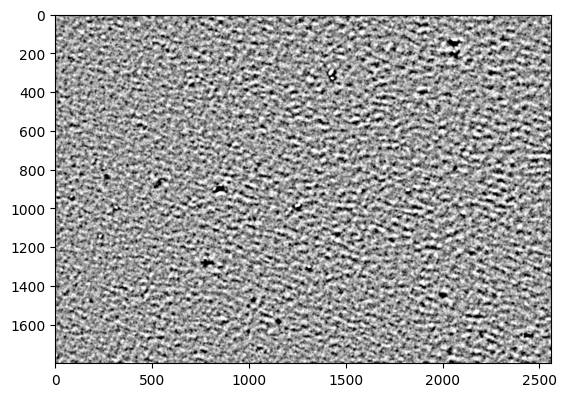

In [32]:
plt.imshow(clean_image(read_image(10)), cmap='gray')

In [33]:
# make array to feed to sindy

sindy_data = []
for number in [i for i in range(50)]:
    arr = read_image(number+1)
    clean_arr = clean_image(arr)

    sindy_data.append(clean_arr)

data = np.array(sindy_data)
data.shape  # (50, 1800, 1800)

(50, 1800, 2560)

## Our SINDy